Using cpu


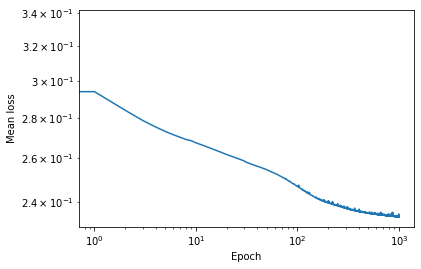

In [222]:
import numpy as np
import pickle

import scipy
from scipy import ndimage
import scipy.optimize as opt
from scipy import signal

import torch
import torch.nn as nn
import torch.optim as optim

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import animation, rc

from IPython.display import HTML
%matplotlib inline

# Import custom modules
from lib.FramesDataset import FramesDataset
from lib import network

# Global variables
HIDDEN_UNITS = 1600
FRAME_SIZE = 15
WARMUP = 4
MODE = 'hierarchical'
T_STEPS = 20

PATHS = [
    'hierarchical-233450examples-15framesize-45tsteps-4warmup-2000epochs-1600units-0.0001lr-0.25gradclip-1e-06L1/0.5beta'
]
PATH = PATHS[0]

# Set device to use on network
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using", DEVICE)

# Load previously trained model
model = network.RecurrentTemporalPrediction.load(
    hidden_units = HIDDEN_UNITS,
    frame_size = FRAME_SIZE,
    warmup = WARMUP,
    mode = MODE,
    path = './models/' + PATH + '.pt'
)

# Load dataset
if False:
    train_dataset = FramesDataset('./datasets/processed_dataset_15px_20tsteps.npy', 'train', WARMUP)
    train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128)
    print("Training dataset length:", len(train_dataset))

# Plot loss history
with open('./models/' + PATH + '.pickle', 'rb') as p:
    loss_history = pickle.load(p)
    
plt.loglog(loss_history);
plt.xlabel('Epoch')
plt.ylabel('Mean loss')
plt.show() 

In [150]:
# Load or save previously generated physiology data

mode = 'SAVE'
path = './virtual_physiology/' + PATH + '.pickle'

if mode == 'SAVE':
    data = {
        "physiology_data_group1": physiology_data_group1,
        "physiology_data_group2": physiology_data_group2,
        "averaged_stimuli_group1": averaged_stimuli_group1,
        "averaged_stimuli_group2": averaged_stimuli_group2
    }

    with open(path, 'wb') as handler:
        pickle.dump(data, handler)
elif mode == 'LOAD':
    with open(path, 'rb') as handler:
        data = pickle.load(handler)
        
        physiology_data_group1 = data["physiology_data_group1"]
        physiology_data_group2 = data["physiology_data_group2"]
        averaged_stimuli_group1 = data["averaged_stimuli_group1"]
        averaged_stimuli_group2 = data["averaged_stimuli_group2"]

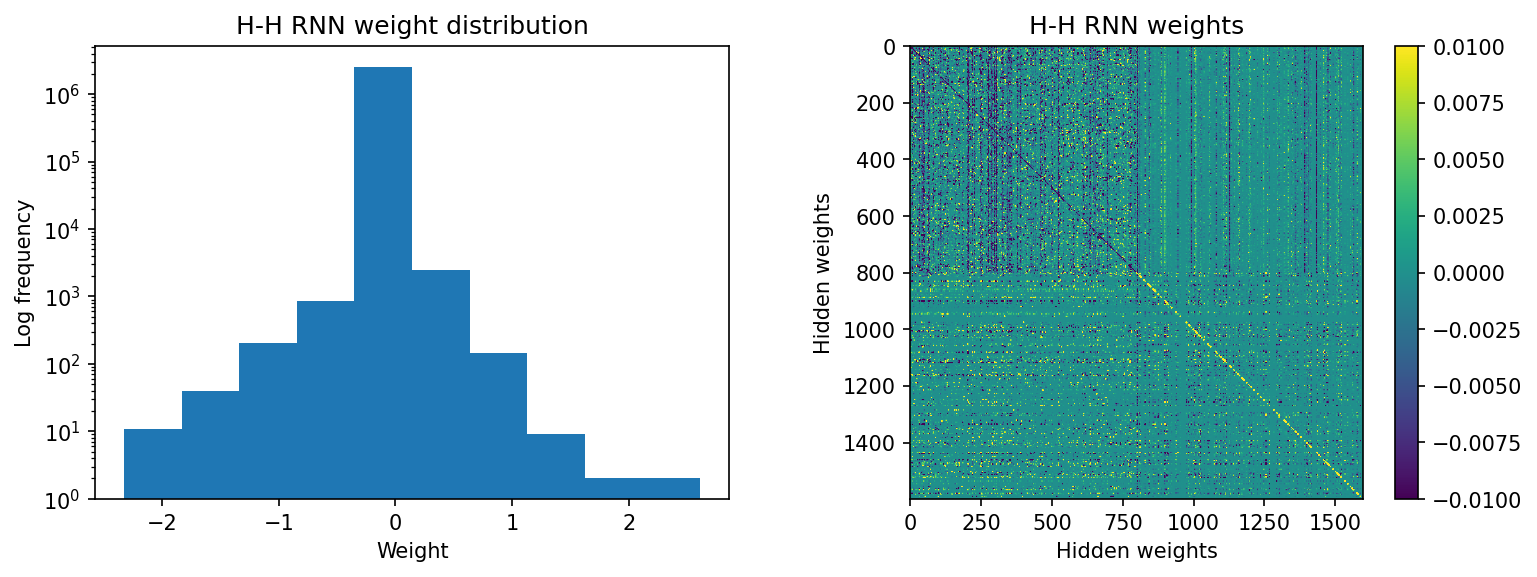

In [2]:
# Plot weight matrices and weights distribution
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(1/3), dpi=150)

axs[0].hist(model.rnn.weight_hh_l0.cpu().detach().numpy().flat, log=True)
axs[0].set_xlabel('Weight')
axs[0].set_ylabel('Log frequency')
axs[0].set_title('H-H RNN weight distribution')

im = axs[1].imshow(model.rnn.weight_hh_l0.cpu().detach().numpy(), vmin=-0.01, vmax=0.01)
axs[1].set_xlabel('Hidden weights')
axs[1].set_ylabel('Hidden weights')
axs[1].set_title("H-H RNN weights")
plt.colorbar(im)

In [3]:
# Produce spike-triggered average
def max_abs_normalize (arr):
    return arr / np.max(np.abs(arr))

def normalize (arr):
    return np.array([
        (lambda a: (a-np.mean(a)) / np.std(a))(b)
        for b in arr
    ])

n_rand_stimuli = 250

stimuli = {}
unit_activity = {}

for i in range(HIDDEN_UNITS):
    stimuli[i] = []
    unit_activity[i] = []

for i in range(n_rand_stimuli):
    if i % 10 == 9:
        print('Random noise trial {}'.format(i+1))
    
    noise_shape = (1, WARMUP+T_STEPS, FRAME_SIZE**2)
    noise = np.random.normal(loc=0, scale=1, size=noise_shape)
    noise = torch.Tensor(noise).to(DEVICE)
    
    _, hidden_state = model(noise)
    
    for t_step in range(WARMUP, WARMUP+T_STEPS):
        units = hidden_state[0, t_step, :] # Output t_step
        for i, unit in enumerate(units):
            if unit > 0:
                weighted_stimulus = noise[0, t_step, :] * unit
                stimuli[i].append(weighted_stimulus.cpu().detach().numpy())
                unit_activity[i].append(unit.cpu().detach().numpy())
                
averaged_stimuli_group1 = [], []
averaged_stimuli_group2 = [], []

for i in range(HIDDEN_UNITS):
    if i % 100 == 99:
        print('Averaging across hidden unit {}'.format(i+1))
    
    stimuli_len = len(stimuli[i])
    if stimuli_len:
        stimulus = np.sum(stimuli[i], 0)/np.sum(unit_activity[i]) # Weighted average

        if i < HIDDEN_UNITS//2:
            averaged_stimuli_group1[0].append(stimulus)
            averaged_stimuli_group1[1].append(i)
        else:
            averaged_stimuli_group2[0].append(stimulus)
            averaged_stimuli_group2[1].append(i)
averaged_stimuli_group1 = np.array(averaged_stimuli_group1[0]), np.array(averaged_stimuli_group1[1])
averaged_stimuli_group2 = np.array(averaged_stimuli_group2[0]), np.array(averaged_stimuli_group2[1])
        
print('Finished averaging stimuli')

Random noise trial 10
Random noise trial 20
Random noise trial 30
Random noise trial 40
Random noise trial 50
Random noise trial 60
Random noise trial 70
Random noise trial 80
Random noise trial 90
Random noise trial 100
Random noise trial 110
Random noise trial 120
Random noise trial 130
Random noise trial 140
Random noise trial 150
Random noise trial 160
Random noise trial 170
Random noise trial 180
Random noise trial 190
Random noise trial 200
Random noise trial 210
Random noise trial 220
Random noise trial 230
Random noise trial 240
Random noise trial 250
Averaging across hidden unit 100
Averaging across hidden unit 200
Averaging across hidden unit 300
Averaging across hidden unit 400
Averaging across hidden unit 500
Averaging across hidden unit 600
Averaging across hidden unit 700
Averaging across hidden unit 800
Averaging across hidden unit 900
Averaging across hidden unit 1000
Averaging across hidden unit 1100
Averaging across hidden unit 1200
Averaging across hidden unit 1300
A

In [131]:
# Virtual physiology

# Constants
OSI_THRESH = 0.4 # Both from Ko et al. (2011)
DSI_THRESH = 0.3

MEAN_RESPONSE_OFFSET = 5
CURVE_FIT_OFFSET = 5

GRATING_AMPLITUDE = 3

SPATIAL_FREQUENCIES = np.arange(1/FRAME_SIZE, 0.5, 1/FRAME_SIZE) # Cycles / pixel
ORIENTATIONS = np.arange(0, 370, 5) # Degrees
TEMPORAL_FREQUENCIES = np.arange(0.05, 0.55, 0.05) # Cycles / time step

def get_f_value (activity):
    # Fit to sine
    def func(x, a, b, c, d, e):
        return e*x + a*np.sin(b*x + c) + d

    params = []
    mse = []
    increment = []

    MSE_threshold = 5

    # Because the unit output has a floor of 0, the curve optimizer function might
    # fail to fit the function unless we shift the unit's response up
    # Shift it up by 0-150, returning the increment (shift), parameters and MSE for each increment
    for i in range(0, 150, 5):
        x = np.arange(len(activity[CURVE_FIT_OFFSET:]))
        y = np.array(activity[CURVE_FIT_OFFSET:]) + i

        # In case it fails to find optimal parameters, wrap in a try block
        try:
            bounds = (
                [-np.inf, 0, -np.inf, -np.inf, -np.inf],
                [np.inf, np.inf, np.inf, np.inf, np.inf] # Set lower bound of 1 for frequency
            )
            
            optimizedParameters, pcov = opt.curve_fit(func, x, y, method='trf', bounds=bounds);
            y_est = func(x, *optimizedParameters)
            
            params.append(optimizedParameters)
            mse.append(np.mean(np.sum((y-y_est)**2)))
            increment.append(i)
        except:
            continue

    # Return false if no good fits were found for any combination
    if len(params):
        # Get the index of the lowest MSE, use this to find the
        # Corresponding parameters used
        idx = np.argmin(mse)
        best_params = params[idx]
        best_i = increment[idx]
        best_mse = mse[idx]

        f0 = np.mean(activity[CURVE_FIT_OFFSET:]) # Average unit activity
        f1 = (abs(best_params[0])) # Absolute of the amplitude of the fitted sine

        y_est = func(np.arange(len(activity[CURVE_FIT_OFFSET:])), *best_params) - best_i
    
        if best_mse <= MSE_threshold and f0 != 0: # Reject f values for those units with poor sine fits
            return f1/f0, y_est                   # as these are unlikely to be reliable
        else:
            return False, False
    else:
        return False, False

def generate_gratings (spatial_freq, orient, temporal_freq):
    # Convert to measure relative to frame size
    spatial_freq = spatial_freq*FRAME_SIZE
    
    gratings = []
    for i in range(WARMUP+T_STEPS+1):
        extended_val = 4 # For a full field grating, make it 4 times larger than
                         # the frame so it can be cropped when rotated and still be full-field
        extended_size = FRAME_SIZE*extended_val
        crop_slice = slice( # Crop extended size grating to be the same size as the frame
            (extended_size-FRAME_SIZE)//2, (extended_size-FRAME_SIZE)//2+FRAME_SIZE
        )
        
        phase = 2*np.pi*-i*temporal_freq # Shift  by a fraction of how many cycles per time step

        x_range = np.linspace(0, 2*np.pi, num=extended_size)
        y = np.sin(x_range*spatial_freq*extended_val + phase)*GRATING_AMPLITUDE

        grating = np.repeat(y, extended_size, axis=0).reshape((extended_size, extended_size))
        grating = ndimage.rotate(grating, orient-90, reshape=False) # -90 to correct for fact that 'default' is 90deg/horizontal
        grating = grating[crop_slice, crop_slice]
        grating = grating.reshape(FRAME_SIZE**2)
        gratings.append(grating)
    
    gratings = np.array([gratings])
    gratings = torch.Tensor(gratings).to(DEVICE)

    return gratings

# Returns a dict of grating responses { unit_idx: responses_array }
def get_grating_responses (model, grating, unit_idxs):
    responses = {}
    for idx in unit_idxs:
        responses[idx] = []
    
    _, hidden_state = model(grating)
    for t_step in range(WARMUP, WARMUP+T_STEPS):
        for idx in unit_idxs:
            unit_activity = hidden_state[0, t_step, idx]
            responses[idx].append(unit_activity.cpu().detach().numpy())
            
    return responses

# Takes orientation tuning curve at max tf and sf
# Returns DSI, OSI
def get_direction_orientation_selectivity (tuning_curve):    
    dir_pref_idx = np.where(tuning_curve == np.max(tuning_curve))[0]
    dir_pref = ORIENTATIONS[dir_pref_idx][0]
    dir_pref_resp = tuning_curve[dir_pref_idx][0]
    
    dir_opp = (dir_pref + 180) % 360
    dir_opp_idx = np.where(ORIENTATIONS == dir_opp)[0]
    dir_opp_resp = tuning_curve[dir_opp_idx][0]
    
    orient_pref_resp = dir_pref_resp
    
    orient_orth = (dir_pref + 90) % 360
    orient_orth_idx = np.where(ORIENTATIONS == orient_orth)[0]
    orient_orth_resp = tuning_curve[orient_orth_idx][0]
    
    DSI = (dir_pref_resp - dir_opp_resp) / (dir_pref_resp + dir_opp_resp)
    OSI = (orient_pref_resp - orient_orth_resp) / (orient_pref_resp + orient_orth_resp)
    
    return DSI, OSI

# Returns array of physiology data
# { "unit_idx", "tuning_curve", "sf", "orientation", "preferred_response", "f" }
def get_physiology_data (averaged_hidden_units):
    hidden_unit_rfs, hidden_unit_idxs = averaged_hidden_units    
    physiology_data = []

    # Dictionary structures containing mean response and complete response for
    # each sf, orient and tf combination
    unit_responses = {}
    mean_unit_responses = {}
    for idx in hidden_unit_idxs:
        unit_responses[idx] = np.zeros((
            len(SPATIAL_FREQUENCIES),
            len(ORIENTATIONS),
            len(TEMPORAL_FREQUENCIES),
            T_STEPS
        ))
        mean_unit_responses[idx] = np.zeros((
            len(SPATIAL_FREQUENCIES),
            len(ORIENTATIONS),
            len(TEMPORAL_FREQUENCIES)
        ))

        
    count = 0
    max_count = mean_unit_responses[[k for k in mean_unit_responses.keys()][0]].size
        
    # Loop through each sf, orient, tf combination for each unit
    # Add response and mean response to structures
    for sf_idx, sf in enumerate(SPATIAL_FREQUENCIES):
        for deg_idx, deg in enumerate(ORIENTATIONS):
            for tf_idx, tf in enumerate(TEMPORAL_FREQUENCIES):
                gratings = generate_gratings(sf, deg, tf)
                grating_responses = get_grating_responses(model, gratings, hidden_unit_idxs)

                for unit_idx in hidden_unit_idxs:
                    unit_response = grating_responses[unit_idx]
                    # Actual response
                    unit_responses[unit_idx][sf_idx, deg_idx, tf_idx] = unit_response
                    # Mean response
                    mean_unit_responses[unit_idx][sf_idx, deg_idx, tf_idx] = np.mean(unit_response[MEAN_RESPONSE_OFFSET:])                                                                                        
                
                if count % 100 == 99:
                    print("Finished param combination {}/{}".format(count+1, max_count)) 
                count += 1
    print("Finished tuning curve")

    for i, unit_idx in enumerate(mean_unit_responses):
        # Get argmax of tuning curve parameters
        tuning_curve = mean_unit_responses[unit_idx]
        sf_idx, orient_idx, tf_idx = np.where(tuning_curve == np.max(tuning_curve))
        
        max_sf = SPATIAL_FREQUENCIES[sf_idx[0]]
        max_orient = ORIENTATIONS[orient_idx[0]]
        max_tf = TEMPORAL_FREQUENCIES[tf_idx[0]]
        max_grating_response = unit_responses[unit_idx][sf_idx[0], orient_idx[0], tf_idx[0]]
        
        # Get f value and estimated sine curve fit
        f, y_est = get_f_value(max_grating_response)
        
        # Get OSI and DSI measures
        DSI, OSI = get_direction_orientation_selectivity(
            tuning_curve[sf_idx[0], :, tf_idx[0]]
        )
        
        # Append all physiology values to datastructure
        physiology_data.append({
            "unit_idx": unit_idx,
            "rf": hidden_unit_rfs[np.where(hidden_unit_idxs == unit_idx)[0]],
            "tuning_curve": tuning_curve,
            "sf": max_sf,
            "orientation": max_orient % 180,
            "direction": max_orient,
            "tf": max_tf,
            "DSI": DSI,
            "OSI": OSI,
            "preferred_response": max_grating_response,
            "mean_response": np.mean(max_grating_response),
            "f": f,
            "y_est": y_est
        })

        if i % 100 == 99:
            print("Finished unit {} / {}".format(i+1, len(hidden_unit_idxs)))

    print("Finished all physiology data processing")
    
    # Reject low mean response units (< 1% of max mean response)
    physiology_data = np.array(physiology_data)
    physiology_data_mean_resp = np.array([u["mean_response"] for u in physiology_data])
    thresh = max(physiology_data_mean_resp) * 0.01 # Get 1% of max mean value
    physiology_data = physiology_data[physiology_data_mean_resp >= thresh]

    return physiology_data

physiology_data_group1 = get_physiology_data(averaged_stimuli_group1)
physiology_data_group2 = get_physiology_data(averaged_stimuli_group2)

Finished param combination 100/5180
Finished param combination 200/5180
Finished param combination 300/5180
Finished param combination 400/5180
Finished param combination 500/5180
Finished param combination 600/5180
Finished param combination 700/5180
Finished param combination 800/5180
Finished param combination 900/5180
Finished param combination 1000/5180
Finished param combination 1100/5180
Finished param combination 1200/5180
Finished param combination 1300/5180
Finished param combination 1400/5180
Finished param combination 1500/5180
Finished param combination 1600/5180
Finished param combination 1700/5180
Finished param combination 1800/5180
Finished param combination 1900/5180
Finished param combination 2000/5180
Finished param combination 2100/5180
Finished param combination 2200/5180
Finished param combination 2300/5180
Finished param combination 2400/5180
Finished param combination 2500/5180
Finished param combination 2600/5180
Finished param combination 2700/5180
Finished p

In [ ]:
def plot_grating_animation (gratings): # Will only work when called (or output called)
                                       # at end of notebook
    fig = plt.figure(dpi=40)
    init_data = gratings.cpu().detach().numpy()[0, 0].reshape(FRAME_SIZE, FRAME_SIZE)
    im = plt.imshow(init_data, cmap='gray')
    plt.title("Grating stimulus", size=20)
    plt.close()
    def animate(i):
        im_data = gratings.cpu().detach().numpy()[0, i].reshape(FRAME_SIZE, FRAME_SIZE)
        im.set_array(im_data)
        return [im]
    anim = animation.FuncAnimation(
        fig, animate,
        frames=WARMUP+T_STEPS, interval=100
    )
    
    return HTML(anim.to_jshtml())

# Graphs is an array of ["rf", "tuning_curve", "preferred_response"]
def plot_physiology_data (unit, graphs):
    if "rf" in graphs:
        sta = normalize(unit["rf"])
        fig = plt.figure(dpi=40)
        plt.imshow(sta.reshape(FRAME_SIZE, FRAME_SIZE), cmap='gray')
        plt.title('Normalized SA', size=25)
        plt.show()

    if "tuning_curve" in graphs:
        tf_idx = np.where(TEMPORAL_FREQUENCIES == unit["tf"])[0][0]

        fig, ax = plt.subplots(dpi=100)
        plt.imshow(unit["tuning_curve"][:, :, tf_idx])
        plt.colorbar()
        plt.xlabel("Orientation")
        plt.xticks(range(len(ORIENTATIONS)), ORIENTATIONS, size=6)
        plt.ylabel("SF")
        plt.yticks(range(len(SPATIAL_FREQUENCIES)), np.round(SPATIAL_FREQUENCIES, 2), size=6)
        plt.title("Max unit activity as a function of orientation and SF", size=8)
        
        for index, label in enumerate(ax.xaxis.get_ticklabels()):
            if (index % 4) != 0:
                label.set_visible(False)
        
        plt.show()

    if "preferred_response" in graphs:
        fig = plt.figure()
        plt.plot(unit["preferred_response"])
        if unit["f"]:
            plt.plot(np.arange(CURVE_FIT_OFFSET, T_STEPS), unit["y_est"])
        plt.xlabel("Frame")
        plt.ylabel("Activity")
        #plt.ylim([0, 5])
        plt.title(
            "F = {}, SF = {}, orientation = {}, TF = {}, unit {}".format(
                round(unit["f"],2), round(unit["sf"], 2), unit["orientation"], round(unit["tf"],2), unit["unit_idx"]
            )
        )
        plt.show()

for unit in physiology_data_group1[:10]:    
    plot_physiology_data(unit, ["preferred_response"])
    print("OSI = {}, DSI = {}".format(unit["OSI"], unit["DSI"]))

In [ ]:
# Spatial localisation of units

def generate_gabors (sf, orientation, tf, gabor_size, row, col):
    # Code sample from https://stackoverflow.com/a/46892763
    def gkern(kernlen, std):
        gkern1d = signal.gaussian(kernlen, std=std).reshape(kernlen, 1)
        gkern2d = np.outer(gkern1d, gkern1d)
        return gkern2d

    gabor_envelope = gkern(gabor_size, gabor_size/5)
    gratings = generate_gratings(sf, orientation, tf).reshape(-1, FRAME_SIZE, FRAME_SIZE)

    im_width = FRAME_SIZE+gabor_size
    im = np.zeros((im_width, im_width)) # Padded size to frame + half of gabor width on each side
    im[row:row+gabor_size, col:col+gabor_size] = gabor_envelope # Set gabor envelope at x,y position
    im = im[gabor_size//2:FRAME_SIZE+gabor_size//2, gabor_size//2:FRAME_SIZE+gabor_size//2] # Crop to remove padding
    gabor = im * gratings.cpu().detach().numpy() # Convolve grating with gaussian kernel
    gabor = gabor.reshape((-1, FRAME_SIZE**2))
    gabor = torch.Tensor(gabor).unsqueeze(0).to(DEVICE)

    return gabor

def get_spatial_position (unit):
    unit_idx = unit["unit_idx"]
    
    gabor_sizes = [8, 14, 20, 40]
    spatial_responses = np.zeros((len(gabor_sizes), FRAME_SIZE, FRAME_SIZE)) # (gabor size, x pos, y pos)
    
    for i, gabor_size in enumerate(gabor_sizes):
        for row in range(FRAME_SIZE):
            for col in range(FRAME_SIZE):
                gabors = generate_gabors(unit["sf"], unit["orientation"], unit["tf"], gabor_size, row, col)
                response = get_grating_responses(model, gabors, [unit_idx])[unit_idx]
                spatial_responses[i, row, col] = np.mean(response[MEAN_RESPONSE_OFFSET:])

    weighted_max_rows, weighted_max_cols, response_weights = [], [], []
    for gabor_size in range(len(gabor_sizes)): # Get location of max response for each gabor size
        responses = spatial_responses[gabor_size]

        max_response = np.max(responses)
        max_row, max_col = np.where(responses == max_response)

        weighted_max_rows.append(max_row[0]*max_response)
        weighted_max_cols.append(max_col[0]*max_response)
        response_weights.append(max_response)
    
    if np.sum(response_weights) == 0: # We couldn't find a gabor that gave a response :(
        return -1, -1
    else:
        mean_max_row = int(round(np.sum(weighted_max_rows) / np.sum(response_weights)))
        mean_max_col = int(round(np.sum(weighted_max_cols) / np.sum(response_weights)))
        return mean_max_row, mean_max_col

def get_group_spatial_positions (physiology_data):
    for i, unit in enumerate(physiology_data): 
        position = get_spatial_position(unit)
        physiology_data[i]["position"] = position
        
        print("Processed unit {} / {}".format(i+1, len(physiology_data)))
    print("\nProcessed all units\n")
    
get_group_spatial_positions(physiology_data_group1)
get_group_spatial_positions(physiology_data_group2)

Processed unit 1 / 800
Processed unit 2 / 800
Processed unit 3 / 800
Processed unit 4 / 800
Processed unit 5 / 800
Processed unit 6 / 800
Processed unit 7 / 800
Processed unit 8 / 800
Processed unit 9 / 800
Processed unit 10 / 800
Processed unit 11 / 800
Processed unit 12 / 800
Processed unit 13 / 800
Processed unit 14 / 800
Processed unit 15 / 800
Processed unit 16 / 800
Processed unit 17 / 800
Processed unit 18 / 800
Processed unit 19 / 800
Processed unit 20 / 800
Processed unit 21 / 800
Processed unit 22 / 800
Processed unit 23 / 800
Processed unit 24 / 800
Processed unit 25 / 800
Processed unit 26 / 800
Processed unit 27 / 800
Processed unit 28 / 800
Processed unit 29 / 800
Processed unit 30 / 800
Processed unit 31 / 800
Processed unit 32 / 800
Processed unit 33 / 800
Processed unit 34 / 800
Processed unit 35 / 800
Processed unit 36 / 800
Processed unit 37 / 800
Processed unit 38 / 800
Processed unit 39 / 800
Processed unit 40 / 800
Processed unit 41 / 800
Processed unit 42 / 800
P

In [ ]:
# for each group 2 unit, find all connected group 1 units and as
hh_weights = model.rnn.weight_hh_l0.cpu().detach().numpy()
thresh = np.std(hh_weights)*2.5

group_2_row = []
group_2_col = []

group_1_row = []
group_1_col = []

for pre_unit in physiology_data_group2:
    pre_unit_idx = pre_unit["unit_idx"]
    pre_unit_row, pre_unit_col = pre_unit["position"]
    
    post_unit_weights = []
    post_unit_rows = []
    post_unit_cols = []
    
    for post_unit in physiology_data_group1:
        post_unit_idx = post_unit["unit_idx"]
        post_unit_row, post_unit_col = post_unit["position"]
        abs_weight = abs(hh_weights[post_unit_idx, pre_unit_idx])

        if abs_weight > thresh:
            group_2_row.append(pre_unit_row)
            group_2_col.append(pre_unit_col)
            group_1_row.append(post_unit_row) # (np.sum(post_unit_rows)/np.sum(post_unit_weights))
            group_1_col.append(post_unit_col) # (np.sum(post_unit_cols)/np.sum(post_unit_weights))
      
    if False:
        fig = plt.figure()
        plt.scatter([post_unit_rows], [post_unit_cols])
        plt.scatter([pre_unit_row], [pre_unit_col], c='red')
        plt.show()

        if len(post_unit_rows) and len(post_unit_cols):
            group_2_row.append(pre_unit_row)
            group_2_col.append(pre_unit_col)
            group_1_row.append(np.mean(post_unit_rows)) # (np.sum(post_unit_rows)/np.sum(post_unit_weights))
            group_1_col.append(np.mean(post_unit_cols)) # (np.sum(post_unit_cols)/np.sum(post_unit_weights))
                    
coef_xpos = np.polyfit(group_1_col, group_2_col, 1)
xregression_xpos = np.arange(0, 15)
yregression_xpos = np.poly1d(coef_xpos)(xregression_xpos)

coef_ypos = np.polyfit(group_1_row, group_2_row, 1)
xregression_ypos = np.arange(0, 15)
yregression_ypos = np.poly1d(coef_ypos)(xregression_ypos)

        
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(1/2), sharex=True, sharey=True)
axs[0].plot(group_1_col, group_2_col, 'bo', xregression_xpos, yregression_xpos, '--k')
axs[0].set_xlabel("Group 1 x")
axs[0].set_ylabel("Group 2 x")
axs[0].set_title("X position")

axs[1].plot(group_1_row, group_2_row, 'bo', xregression_ypos, yregression_ypos, '--k')
axs[1].set_xlim([0,15])
axs[1].set_ylim([0,15])
axs[1].set_xlabel("Group 1 y")
axs[1].set_ylabel("Group 2 y")
axs[1].set_title("Y position")

plt.show()

x_position_test = scipy.stats.pearsonr(group_1_col, group_2_col)
y_position_test = scipy.stats.pearsonr(group_1_row, group_2_row)

x_position_test, y_position_test

Text(-0.025, 0.5, 'Postsynaptic unit')

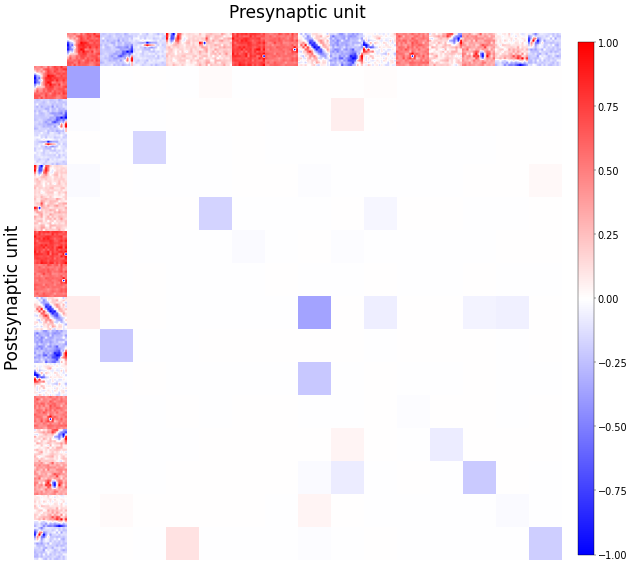

In [121]:
# Visualise connections between recurrent units
averaged_stimuli = averaged_stimuli_group1

starting_idx = 0
n_units = 15
units_slice = slice(starting_idx, starting_idx+n_units)

hh_indices = averaged_stimuli[1][units_slice]
hh_weights = model.rnn.weight_hh_l0.cpu().detach().numpy()
hh_weights_subset = np.zeros(shape=(n_units, n_units))

for row in range(n_units):
    for col in range(n_units):
        hh_weights_subset[row, col] = hh_weights[hh_indices[row], hh_indices[col]]

sta_RFs = max_abs_normalize(averaged_stimuli_group1[0][units_slice])

cols = n_units + 1
rows = n_units + 1

fig, f_axs = plt.subplots(
    dpi=35,
    ncols=cols,
    nrows=rows,
    figsize=(cols, rows),
    gridspec_kw=dict(wspace=0.0, hspace=0.0,
                     top=1. - 0.5 / (rows + 1), bottom=0.5 / (rows + 1),
                     left=0.5 / (cols + 1), right=1 - 0.5 / (cols + 1)),
)
gs = f_axs[0, 0].get_gridspec()

for axs in f_axs[1:, 1:]:
    for ax in axs:
        ax.remove()
axbig = fig.add_subplot(gs[1:, 1:])
axbig.set_axis_off()
im = axbig.imshow(hh_weights_subset, cmap='bwr', vmax=1, vmin=-1)

cbaxes = fig.add_axes([1, 0.04, 0.03, 0.915]) 
cb = plt.colorbar(im, cax = cbaxes)
for t in cb.ax.get_yticklabels():
    t.set_fontsize(20)

count = 0
for ax_row in f_axs:
    for ax in ax_row:
        ax.set_axis_off()
        
        if count > 0 and count < n_units+1: # X-axis row
            unit_n = count-1
        elif count % (n_units+1) == 0: # Y-axis row
            unit_n = count//(n_units+1) - 1
        else:
            unit_n = -1
            
        if unit_n > -1:
            unit = np.reshape(sta_RFs[unit_n], (FRAME_SIZE, FRAME_SIZE))
            ax.imshow(unit, cmap='bwr')
            
        count += 1
        
fig.text(0.5, 1, 'Presynaptic unit', ha='center', fontsize=35)
fig.text(-0.025, 0.5, 'Postsynaptic unit', va='center', rotation='vertical', fontsize=35)

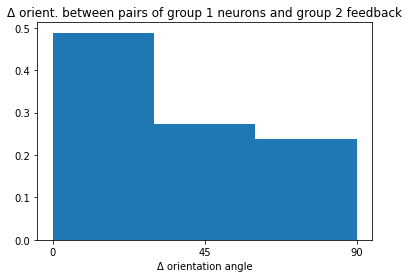

Text(0.5, 1.0, 'Group 2')

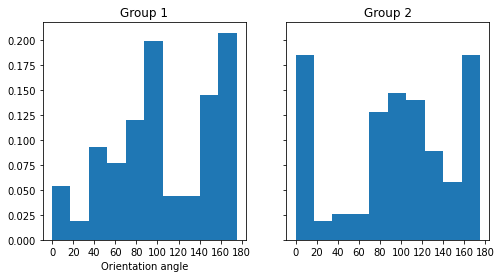

In [219]:
# Plot distribution of connection orientations

orientations_1 = []
orientations_2 = []

# Only include those with OSI > 0.4
for unit in physiology_data_group1:
    if unit["OSI"] > OSI_THRESH:
        orientations_1.append(unit["orientation"])
for unit in physiology_data_group2:
    if unit["OSI"] > OSI_THRESH:
        orientations_2.append(unit["orientation"])
        
orientations_1 = np.array(orientations_1)  
orientations_2 = np.array(orientations_2)  
        
weights = model.rnn.weight_hh_l0.cpu().detach().numpy()
weights = (weights-np.mean(weights))/np.std(weights)
weight_thresh = 2

mean_orientation_deltas = []

for post_unit_1 in physiology_data_group1:
    unit_orientation_deltas = []
    unit_weights = []
    
    for pre_unit_2 in physiology_data_group2:
        connection_weight = abs(weights[post_unit_1["unit_idx"], pre_unit_2["unit_idx"]])
        a1, a2 = 0, 0
        if False: # Use random orientations
            a1, a2 = np.random.choice(orientations_1), np.random.choice(orientations_2)
        else:     # Use true orientations
            a1, a2 = pre_unit_2["orientation"], post_unit_1["orientation"]
        a_delta = 90 - abs(abs(a1 - a2) - 90);
        
        if connection_weight > weight_thresh and post_unit_1["OSI"] > OSI_THRESH and pre_unit_2["OSI"] > OSI_THRESH:
            unit_orientation_deltas.append(a_delta*connection_weight)
            mean_orientation_deltas.append(a_delta)
        unit_weights.append(connection_weight)
    
    #mean_orientation_deltas.append(np.sum(unit_orientation_deltas)/np.sum(unit_weights))

mean_orientation_deltas = np.array(mean_orientation_deltas)
hist_weights = np.ones_like(mean_orientation_deltas) / float(len(mean_orientation_deltas))

# Plot differences
fig, ax = plt.subplots()
ax.hist(mean_orientation_deltas, bins=3, weights=hist_weights)
ax.set_title("Δ orient. between pairs of group 1 neurons and group 2 feedback")
ax.set_xlabel("Δ orientation angle")
ax.set_xticks([0, 45, 90])
plt.show()

# Plot overall orientation distribution
hist_weights_1 = np.ones_like(orientations_1) / float(len(orientations_1))
hist_weights_2 = np.ones_like(orientations_2) / float(len(orientations_2))

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(1/2) , sharex=True, sharey=True)
axs[0].hist(orientations_1, bins=10, weights=hist_weights_1)
axs[0].set_title("Group 1")
axs[0].set_xlabel("Orientation angle")
axs[0].set_xticks(np.arange(0, 200, 20))
axs[0].set_xticklabels(np.arange(0, 200, 20))
axs[1].hist(orientations_2, bins=10, weights=hist_weights_2)
axs[1].set_title("Group 2")

Power_divergenceResult(statistic=array([25.17304493, 19.84057971]), pvalue=array([5.24096192e-07, 8.41765383e-06]))

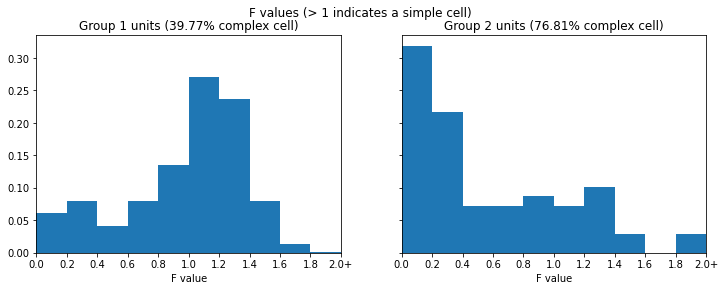

In [215]:
outlier_thresh = 2

max_mean_response_1 = max(u['mean_response'] for u in physiology_data_group1)
max_mean_response_2 = max(u['mean_response'] for u in physiology_data_group2)

f_values_1 = []
for unit in physiology_data_group1:
    f = unit["f"]
    if f != False and unit["mean_response"] > (0.01*max_mean_response_1):
        f_values_1.append(f)
f_values_1 = np.array(f_values_1)
weights_1 = np.ones_like(f_values_1) / float(len(f_values_1))
complex_cell_prop_1 = round(len(f_values_1[f_values_1 <= 1]) / len(f_values_1) * 100, 2)
    
f_values_2 = []
for unit in physiology_data_group2:
    f = unit["f"]
    if f != False and unit["mean_response"] > (0.01*max_mean_response_2):
        f_values_2.append(f)
f_values_2 = np.array(f_values_2)
weights_2 = np.ones_like(f_values_2) / float(len(f_values_2))
complex_cell_prop_2 = round(len(f_values_2[f_values_2 <= 1]) / len(f_values_2) * 100, 2)

bins = np.arange(0, outlier_thresh+0.1, 0.1)
xlabels = np.round(bins, 1).astype(str)
xlabels[-1] += '+'
nlabels = len(xlabels)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(1/3), sharex=True, sharey=True)
axs[0].hist(np.clip(f_values_1, bins[0], bins[-1]), bins=bins, weights=weights_1)
axs[0].set_title("Group 1 units ({}% complex cell)".format(complex_cell_prop_1))
axs[0].set_xlabel("F value")
axs[0].set_xticks(bins)
axs[0].set_xticklabels(xlabels)
axs[0].set_xlim([0, outlier_thresh])

axs[1].hist(np.clip(f_values_2, bins[0], bins[-1]), bins=bins, weights=weights_2)
axs[1].set_title("Group 2 units ({}% complex cell)".format(complex_cell_prop_2))
axs[1].set_xlabel("F value")
fig.suptitle('F values (> 1 indicates a simple cell)')

f_values_1_complex = len(f_values_1[f_values_1 <= 1])
f_values_2_complex = len(f_values_2[f_values_2 <= 1])
f_values_1_simple = len(f_values_1[f_values_1 > 1])
f_values_2_simple = len(f_values_2[f_values_2 > 1])

chi_sq = np.array([
    [f_values_1_complex, f_values_2_complex],
    [f_values_1_simple, f_values_2_simple]
])

scipy.stats.chisquare(chi_sq)

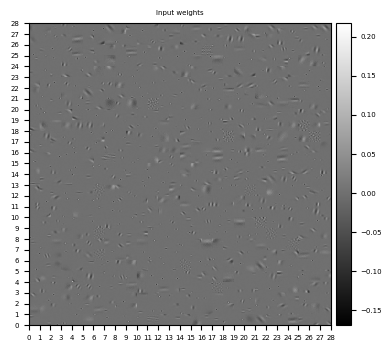

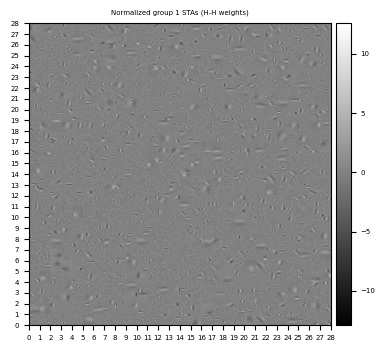

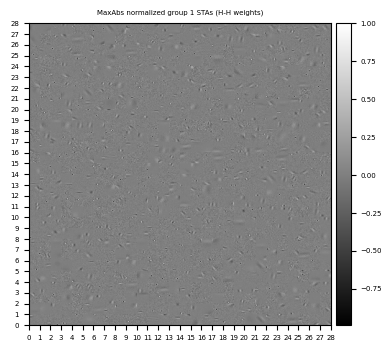

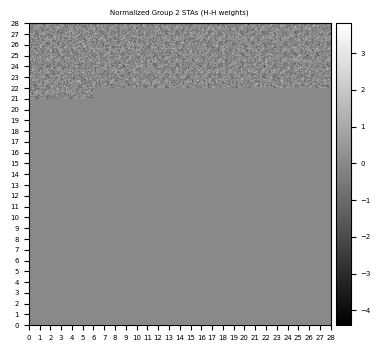

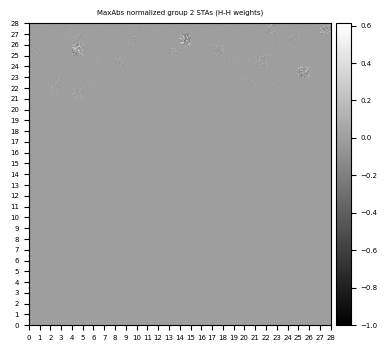

In [221]:
#Plot spike triggered averages and input weights
def plot_weights (weights_array, rows, columns, offset = 0, title = ""):
    font_size = 5
    weights = weights_array[offset:offset+rows*columns, :]
    im = np.zeros((rows*FRAME_SIZE, columns*FRAME_SIZE))
    
    for row in range(rows):
        for column in range(columns):
            idx = row*columns + column
            hidden_unit_weights = np.zeros(FRAME_SIZE**2) # Pad image if no more weights to show
            if idx < len(weights):
                hidden_unit_weights = weights[idx]
            hidden_unit_weights = np.reshape(hidden_unit_weights, (FRAME_SIZE, FRAME_SIZE))
            im[row*FRAME_SIZE:(row+1)*FRAME_SIZE, column*FRAME_SIZE:(column+1)*FRAME_SIZE] = hidden_unit_weights

    fig, ax = plt.subplots(dpi=100)
    im_plt = plt.imshow(im, extent=[0, columns, 0, rows], cmap='gray')
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cb_plt = plt.colorbar(im_plt, cax=cax)
    cb_plt.ax.tick_params(labelsize=font_size)

    ax.set_xticks(np.arange(0, columns+1))
    ax.set_xticklabels(np.arange(0, columns+1), size=font_size)
    ax.set_yticks(np.arange(0, rows+1))
    ax.set_yticklabels(np.arange(0, rows+1), size=font_size)
    #ax.grid(which='major', color='w', linestyle='-', linewidth=0.5)
    ax.set_title(title, size=font_size)

rows, columns, offset = (28, 28, 0)
plot_weights(model.rnn.weight_ih_l0.cpu().detach().numpy(), rows, columns, offset, "Input weights")

plot_weights(normalize(averaged_stimuli_group1[0]), rows, columns, offset, "Normalized group 1 STAs (H-H weights)")
plot_weights(max_abs_normalize(averaged_stimuli_group1[0]), rows, columns, offset, "MaxAbs normalized group 1 STAs (H-H weights)")
plot_weights(normalize(averaged_stimuli_group2[0]), rows, columns, offset, "Normalized Group 2 STAs (H-H weights)")
plot_weights(max_abs_normalize(averaged_stimuli_group2[0]), rows, columns, offset, "MaxAbs normalized group 2 STAs (H-H weights)")